<a href="https://colab.research.google.com/github/realBarnaby/projects/blob/main/DL_beadando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Beadandó feladat!

Deep Learning 2024 beadandó feladat!

Készítsen az alábbiakban letölthető fájlok segítségével egy a röntgen felvételeket értékelő bináris osztályozót. A felvételeken egészséges és beteg emberekhez tartozó röntgen képek találhatóak.
A feladatot konvolúciós neurális hálózat segítségével valósítsa meg!
Használjon korai leállítást, értékelje a modellt annak a pontosságával!
Rajzolja ki a költségfügvény alakaulását (Loss) és szövegesen értékelje ki!
Az elkészült modellt mentse el.
A test adatokon értékelje a modelljét!
A legjobb eredményt (pontosságot) folyamatosan megosztom a Teamsben.

Többször is lehet megoldást beküldeni.

Értékelés: az önáltal elért eredmény(pontosság)/legjobb eredmény(pontosság)*100

5: 98-

4: 96-97,99

3: 93-95,99

2: 92,99 alatt

1: nem működik

Beküldési határidő: 2024.december 22.

In [1]:
!gdown 1FfgdLCOpDlJZLp0MGohTh1sf4LgHICrN

Downloading...
From (original): https://drive.google.com/uc?id=1FfgdLCOpDlJZLp0MGohTh1sf4LgHICrN
From (redirected): https://drive.google.com/uc?id=1FfgdLCOpDlJZLp0MGohTh1sf4LgHICrN&confirm=t&uuid=70dbb457-ddae-4332-be02-179433b88a04
To: /content/DL_beadandó.zip
100% 412M/412M [00:03<00:00, 114MB/s]


In [2]:
!unzip DL_beadandó.zip -d XRAY

Archive:  DL_beadandó.zip
   creating: XRAY/test/
   creating: XRAY/test/NORMAL/
  inflating: XRAY/test/NORMAL/IM-0001-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0003-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0005-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0006-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0007-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0009-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0010-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: XRAY/test/NORMAL/IM-0011-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0013-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0015-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0016-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0017-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0019-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0021-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0022-0001.jpeg  
  inflating: XRAY/test/NORMAL/IM-0023-0001.jpeg  
  inflati

In [3]:
 import os
 os.environ['TF_USE_LEGACY_KERAS']='1'

# Ellenőrizzük a GPU-t

In [4]:
!nvidia-smi

Sun Dec 22 21:33:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!pip install split-folders

#Osszuk fel a fájlokat train és test készletre

In [6]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("XRAY", output="XRAY",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=True)

Copying files: 0 files [00:00, ? files/s]


#Töltsük be a képeket ImageDataGenerator segítségével

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "XRAY/train/"
test_dir = "XRAY/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 1000 images belonging to 4 classes.
Testing images:
Found 624 images belonging to 2 classes.


#class_names listába töltsük be az osztályok neveit

In [31]:
import pathlib
import numpy as np
data_dir = pathlib.Path("XRAY/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Create a list of class_nmaes from the subdirectories
print(class_names)

['.ipynb_checkpoints' 'NORMAL' 'PNEUMONIA']


#töltsük le a efficientnetb0 feature vektor modellt

In [21]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [35]:
feature_extractor_layer = hub.KerasLayer(
    efficientnet_url,
    trainable=False,
    name='feature_extraction_layer',
    input_shape=IMAGE_SHAPE+(3,)
)

In [36]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

#állítsuk össze a modellt

In [83]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
# Korai leállítás visszahívás definiálása
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)
# Define the Sequential model
model = tf.keras.Sequential([
    #feature_extractor_layer,  # use the feature extraction layer as the base
    #layers.Dense(3, activation='softmax', name='output_layer')  # create our own output layer
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [16]:
!pip install --upgrade tensorflow tensorflow-hub


In [84]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 26, 26, 10)       

In [85]:
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

0 conv2d_22 True
1 max_pooling2d_22 True
2 conv2d_23 True
3 max_pooling2d_23 True
4 conv2d_24 True
5 max_pooling2d_24 True
6 conv2d_25 True
7 max_pooling2d_25 True
8 conv2d_26 True
9 max_pooling2d_26 True
10 flatten_7 True
11 dense_7 True


#model.compile, fit

In [88]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit EfficientNet model
history = model.fit(train_data, # only use 10% of training data
                    epochs=5, # train for 5 epochs
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
32/32 [==============================] - 18s 500ms/step - loss: 0.6899 - accuracy: 0.4900 - val_loss: 0.6918 - val_accuracy: 0.3862
Epoch 2/5
32/32 [==============================] - 16s 501ms/step - loss: 0.6572 - accuracy: 0.6170 - val_loss: 0.6128 - val_accuracy: 0.8141
Epoch 3/5
32/32 [==============================] - 17s 530ms/step - loss: 0.3622 - accuracy: 0.8700 - val_loss: 0.5256 - val_accuracy: 0.8045
Epoch 4/5
32/32 [==============================] - 16s 507ms/step - loss: 0.1844 - accuracy: 0.9350 - val_loss: 0.5909 - val_accuracy: 0.7596
Epoch 5/5
32/32 [==============================] - 16s 511ms/step - loss: 0.1773 - accuracy: 0.9310 - val_loss: 0.4101 - val_accuracy: 0.8446


#nézzük meg a modell eredményeit

In [89]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

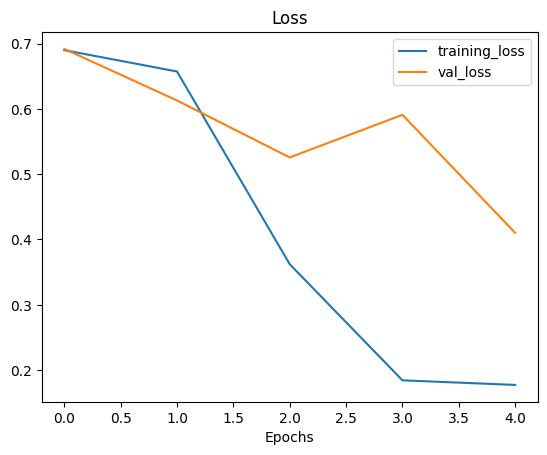

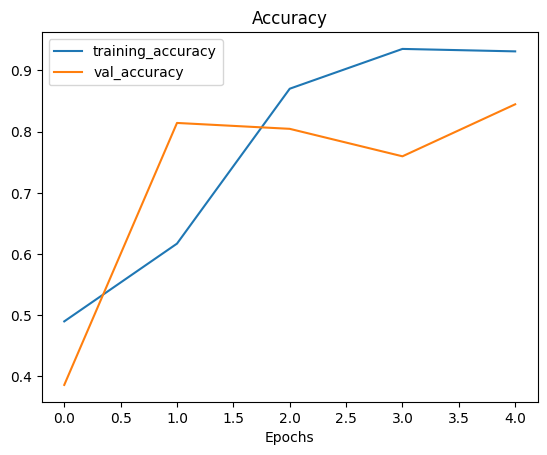

In [90]:
plot_loss_curves(history)

In [91]:
model.save('kesz')

In [92]:
model2 = tf.keras.models.load_model("kesz")

In [93]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)
    # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3) #tensor formatum
    # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = tf.expand_dims(img, axis=0)
  #img  = img[...,::-1]
  img -= [103, 116, 123]
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [94]:
image = load_and_prep_image("/content/XRAY/train/NORMAL/IM-0115-0001.jpeg")

In [95]:
pred = model.predict(image)

1/1 [==============================] - 0s 189ms/step


In [96]:
pred[0]

array([0.0022791], dtype=float32)

In [97]:
np.argmax(pred[0])

0

In [98]:
pred_class = class_names[np.argmax(pred[0])]
pred_class

'.ipynb_checkpoints'